In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geemap import ml
from sklearn.ensemble import RandomForestClassifier

import geemap, ee
import geopandas as gpd

import glob
import os
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import Line2D

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

Enter verification code: 4/1AfJohXn5QRkF69LYs-mSOwSxl3vNRtBOc1DQeLRSqAMV6EOAe6X0B1LWzaM

Successfully saved authorization token.


In [517]:

def mappy(x):
    return ee.String(x).replace('#', '\n', 'g')


def decode_qamask(img: ee.Image) -> ee.Image:
    '''
    Args
    - img: ee.Image, Sentinel 2 image containing 'pixel_qa' band
    Returns
    - masks: ee.Image, 
    Pixel QA Bit Flags
    Bit  Attribute
    0    Fill
    10   Cloud
    11   Cirrus
    '''
    qa = img.select('QA60')
    cloud = qa.bitwiseAnd(1024).eq(0)  # 0 = cloud, 1 = not cloud
    cloud = cloud.updateMask(cloud).rename(['pxqa_cloud'])
    
    cirrus = qa.bitwiseAnd(2048).eq(0)  # 0 = cloud, 1 = not cloud
    cirrus = cirrus.updateMask(cirrus).rename(['pxqa_cirrus'])
    masks = ee.Image.cat([cloud, cirrus])
    return masks


def mask_qaclear(img: ee.Image) -> ee.Image:
    '''
    Args
    - img: ee.Image
    Returns
    - img: ee.Image, input image with cloud, cirrus
        pixels masked out
    '''
    qam = decode_qamask(img)
    cloud_mask = qam.select('pxqa_cloud')
    cirrus_mask = qam.select('pxqa_cirrus')
    return img.updateMask(cloud_mask).updateMask(cirrus_mask).divide(10000)

def getS1_collection(START_DATE, END_DATE):
    #Import Sentinel 1 and filter data series:
    s1Collection =  ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
    .filter(ee.Filter.eq('instrumentMode', 'IW'))\
    .filterDate(START_DATE, END_DATE)
    
    return s1Collection

def getS2_collection(START_DATE, END_DATE, cloud_pct = 10):

    s2Collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                      .filterDate(START_DATE, END_DATE)\
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',cloud_pct))\
                      .map(mask_qaclear)
    
    return s2Collection

def addBands(expr, band_map, name):
    expr_s2 = ee.Image().expression({
        'expression': expr,
      'map': band_map}).rename(name)
    
    return expr_s2

def s1s2_image(START_DATE, END_DATE):

    s1Collection = getS1_collection(START_DATE, END_DATE)

    #Calculate median image of time period
    s1_image = ee.Image(s1Collection.median()) 
    s2 = s2Collection.median()
    
        #### Add S2 Bands
    mTGSI_expr = '(R - B + SWIR2 - NIR) / (R + G + B + SWIR2 + NIR)'  
    mTGSI = s2.expression(mTGSI_expr, 
                          {
                            'R': s2.select('B4'),
                            'G': s2.select('B3'),
                            'B': s2.select('B2'),
                            'NIR': s2.select('B8'),
                            'SWIR2': s2.select('B12'),
                            'SWIR1': s2.select('B11')
                          }).rename('mTGSI')

    BSI_expr = '((RED + SWIR1) - (NIR + BLUE)) / ((RED + SWIR1) + (NIR + BLUE))'
    BSI = s2.expression(BSI_expr, 
                          {
                            'NIR' : s2.select('B8'),
                            'RED' : s2.select('B4'),
                            'SWIR1': s2.select('B11'),
                            'BLUE': s2.select('B2')
                          }).rename('BSI')
    
    
    NDWI_expr = '(GREEN - NIR) / (GREEN + NIR)'
    NDWI = s2.expression(NDWI_expr, 
                          {
                         'NIR' : s2.select('B8'),
                        'GREEN' : s2.select('B3')
                          }).rename('NDWI')

    ### Add Dynamic World
    colFilter = ee.Filter.And(ee.Filter.bounds(ee.Geometry.Point(84.37454, 25.05473)), ee.Filter.date(START_DATE, END_DATE))

    DW = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(colFilter).median()

    nameOfBands = DW.bandNames().remove('label')
    # ['water', 'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']
    DW = DW.select(nameOfBands)


    #### All bands together
    sentinelComp = s2.addBands(s1_image.select([s1_band, s1_band2])).addBands(mTGSI).addBands(BSI).addBands(NDWI)

    outBands =  ["B2","B3","B4","B8","B8A","B11","B12","VV","VH","mTGSI","BSI","NDWI"]

    finalComp= sentinelComp.select(outBands).addBands(DW)
    
    return finalComp


def get_sgr_feat(ee_img, distid):
    
    df_dist1 = gpd.read_file(f"/data/sand_mining/rivers/districts/india-rivers_multipolygons_{distid}.geojson")
    temp1 = geemap.geopandas_to_ee(df_dist1)

    sand_mask = ee_img.eq(1)
    gravel_mask = ee_img.eq(2)

    reduced = sand_mask.reduceRegion(
                  reducer=ee.Reducer.sum(),
                  geometry=temp1,
                  scale=10, 
                  tileScale = 3
                   )

    sand_reduced = ee.Feature(None, reduced)
    sand_reduced = sand_reduced.set('distid', distid)
    sand_reduced = sand_reduced.set('class', 'sand')

    reduced = gravel_mask.reduceRegion(
                  reducer=ee.Reducer.sum(),
                  geometry=temp1,
                  scale=10, 
                  tileScale = 3
                   )

    gravel_reduced = ee.Feature(None, reduced)
    gravel_reduced = gravel_reduced.set('distid', distid)
    gravel_reduced = gravel_reduced.set('class', 'gravel')

    sgr = ee.FeatureCollection([sand_reduced, gravel_reduced])
    
    return sgr


def get_final_classification(image, model):
    #### SNIC
    size_segmentation = 10

    #Segmentation using a SNIC approach based on the dataset previosly generated
    seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation)
    snic = ee.Algorithms.Image.Segmentation.SNIC(**{
      'image': image, #our multi-band image with selected bands same as for pixel-based
      'compactness': 0.8,  #allow flexibility in object shape, no need to force compactness
      'connectivity': 8, #use all 8 neighboring pixels in a pixel neighborhood
      'neighborhoodSize': 256, 
      'seeds': seeds
    })

    ####Classification
    predictionBands=snic.bandNames().remove("clusters") 
    renamed_bands = ['B2_median', 'B3_median', 'B4_median', 'B8_median', 'B8A_median', 'B11_median', 'B12_median', 
    'VV_median', 'VH_median', 'mTGSI_median', 'BSI_median', 'NDWI_median', 'water_median', 'trees_median', 'grass_median', 
    'flooded_vegetation_median', 'crops_median', 'shrub_and_scrub_median', 'built_median', 'bare_median', 'snow_and_ice_median']

    snic = snic.select(predictionBands, renamed_bands)

    classification = snic.classify(model)
    
    return classification


def calculateMean(image):
    mean = image.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': dist_449,
    'scale': 10,  #Adjust the scale according to your needs
    'maxPixels': 1e13, 
    'tileScale':3
      })
    return image.set('mean_value', mean.get('classification'))  #Replace with the actual band name




In [ ]:
#### Load Models

fc = ee.FeatureCollection("projects/gee-sand/assets/RF_sklearn_seg10_n1214_d50_msl1_mss2_mf-None_bTrue")
tree_strings = fc.aggregate_array('tree').map(mappy)
RF = ee.Classifier.decisionTreeEnsemble(tree_strings)

In [123]:
##### Define Globals

s1_band = 'VV'
s1_band2 = 'VH'
s1_band3 = 'angle'

In [124]:
# START_DATE = '2022-01-01'
# END_DATE = '2022-01-31'

# finalComp = s1s2_image(START_DATE, END_DATE)

#### Get predictions for each district at two time periods in 2022

In [513]:
## Pre-monsoon and post-monsoon

date_list = [
#     ('2022-01-01', '2022-01-31'), 
    ('2022-03-01', '2022-05-31'), 
    ('2022-10-01', '2022-11-30')
]

In [515]:
### This portion exports pre and post data (amount of sand and gravel) for each district in India. 

for START_DATE, END_DATE in date_list:
    print(START_DATE, END_DATE)
    finalComp = s1s2_image(START_DATE, END_DATE)
    
    #### SNIC
    size_segmentation = 10

    #Segmentation using a SNIC approach based on the dataset previosly generated
    seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation)
    snic = ee.Algorithms.Image.Segmentation.SNIC(**{
      'image': finalComp, #our multi-band image with selected bands same as for pixel-based
      'compactness': 0.8,  #allow flexibility in object shape, no need to force compactness
      'connectivity': 8, #use all 8 neighboring pixels in a pixel neighborhood
      'neighborhoodSize': 256, 
      'seeds': seeds
    })

    ####Classification
    predictionBands=snic.bandNames().remove("clusters") 
    renamed_bands = ['B2_median', 'B3_median', 'B4_median', 'B8_median', 'B8A_median', 'B11_median', 'B12_median', 
    'VV_median', 'VH_median', 'mTGSI_median', 'BSI_median', 'NDWI_median', 'water_median', 'trees_median', 'grass_median', 
    'flooded_vegetation_median', 'crops_median', 'shrub_and_scrub_median', 'built_median', 'bare_median', 'snow_and_ice_median']

    snic = snic.select(predictionBands, renamed_bands)

    classification = snic.classify(RF)
    print('Classification complete!')
    ### Create SGR Classes
    # classification_sgr = classification.remap([0,3,4,5,6,7],[0,0,0, 0, 0,0])


    files = os.listdir("/data/sand_mining/rivers/districts")
    idlist = [f.split(".")[0].split("_")[2] for f in files]

    ### Create Tasks
    tasks = {}
    for distid in idlist:
        sgr_img = get_sgr_feat(classification, distid)
        task = ee.batch.Export.table.toDrive(
          collection= sgr_img,
          description=f'{distid}_{START_DATE}_{END_DATE}',
          folder = f'sgr_data/{START_DATE}_{END_DATE}',
          fileFormat='CSV'
        )

        task.start()
        tasks[distid] = task
        
    print('Tasks started!')

2022-03-01 2022-05-31
Classification complete!
Tasks started!
2022-10-01 2022-11-30
Classification complete!
Tasks started!


##### Change Analysis -- Get pre-monsoon and post-monsoon images, and examine changes

In [848]:
finalComp_pre = s1s2_image('2022-03-01', '2022-05-31')
finalComp_post = s1s2_image('2022-10-01', '2022-11-30')

In [849]:
classification_pre = get_final_classification(finalComp_pre, RF)
classification_post = get_final_classification(finalComp_post, RF)

In [580]:
##Focus on Bihar

id_list = [448, 449, 450, 452, 457, 458, 459, 462, 466, 471, 485, 487, 496,
       501, 508, 509, 514, 521, 526, 527, 539, 541, 544, 549, 560, 564,
       567, 568, 575, 577, 578, 581, 585, 586, 589, 590, 595, 607]

fpath = "/data/sand_mining/rivers/districts"
df_dists = [ geemap.geopandas_to_ee(gpd.read_file(f"{fpath}/india-rivers_multipolygons_{d}.geojson")) for d in id_list]

In [811]:
river_fc = ee.FeatureCollection([])
for fc in df_dists:
    river_fc = river_fc.merge(fc)
    
    
# Map1 = geemap.Map(center =[25.22123 ,84.57627], zoom = 11)
# Map1.addLayer(river_fc, {'color':'grey'}, 'Rivers - Bihar')
# Map1

In [ ]:
sand_pre = classification_pre.eq(1).clip(river_fc)
sand_post = classification_post.eq(1).clip(river_fc)

sand10 = sand_pre.eq(1).And(sand_post.eq(0))
sand01 = sand_pre.eq(0).And(sand_post.eq(1))
sand11 = sand_pre.eq(1).And(sand_post.eq(1))
sand00 = sand_pre.eq(0).And(sand_post.eq(0))

In [593]:
reduceds = []
for eeobj in [sand10, sand01, sand11, sand00]:
    reduced = eeobj.reduceRegions(
                  reducer=ee.Reducer.sum(),
                  collection=river_fc,
                  scale=10, 
                  tileScale = 3
                   )

    reduceds.append(reduced)
    
    
### THIS IS INCOMPLETE

In [851]:
# counts = reduceds[0].values().get(0)
# counts_keys = ee.Dictionary(counts).keys()
# counts_values = ee.Dictionary(counts).values()

#### Single district

    - Implement the residuals-based approach

In [599]:
df_dist1 = gpd.read_file("/data/sand_mining/rivers/districts/india-rivers_multipolygons_449.geojson")
dist_449 = geemap.geopandas_to_ee(df_dist1)

In [799]:
imgs = ee.List([])
dates = []
for start, end in list(zip(pd.date_range('2018-01-01', '2022-12-31', freq= 'MS' ), 
    pd.date_range('2018-01-01', '2022-12-31', freq= 'M' ))):
    img = s1s2_image(str(start.date()), str(end.date()))
    hasNoBands = img.bandNames()
    a = hasNoBands.length()
    a = a.getInfo()
    if a == 21:
        img = img.clip(dist_449)
        img_class = get_final_classification(img, RF)
        sand = img_class.eq(1)
        sand = sand.set('ym', start.strftime("%Y-%m"))
        imgs = imgs.add(ee.Image(sand))
        dates.append(start.strftime("%Y-%m"))
    
img_coll = ee.ImageCollection.fromImages(imgs)

#Map the function over the Image Collection
imageCollectionWithMean = img_coll.map(calculateMean)

In [802]:
# # Extract mean values as a list
mean_list = imageCollectionWithMean.aggregate_array('mean_value').getInfo()

# Convert the list to a Pandas DataFrame
df = pd.DataFrame({'mean_value': mean_list, 
                    'ym':dates})

df['year'] = df['ym'].apply(lambda x:int(x[:4]))
df['month'] = df['ym'].apply(lambda x:int(x.split("-")[1]))
df['pre'] = df['month'].isin([2, 3, 4, 5])*1
df['post'] = df['month'].isin([10, 11, 12])*1


In [ ]:
df = pd.concat([df, 
                pd.get_dummies(df['year'], drop_first = True, prefix = 'y'), 
               pd.get_dummies(df['month'], drop_first = True, prefix = 'm')], axis = 1)

In [731]:
# import statsmodels.api as sm

# # Assuming df is your DataFrame with columns Y, X1, X2, ..., Xn
# X = df[['pre', 'post', 'y_2022', 'month']]
# X = sm.add_constant(X)  # Add a constant term for intercept
# Y = df['mean_value']

# # Fit the initial linear regression model
# model = sm.OLS(Y, X).fit()

# # Get the residuals
# residuals = model.resid

# # # Residualize with respect to X1
# # Y_res = Y - model.params['X1'] * X['X1']

In [729]:
import statsmodels.formula.api as sms

In [808]:
### Explore alternate residualization option

m = sms.ols('mean_value ~ C(year) + C(month) + pre + post', df).fit()
m.summary()

df['mean_value_resid']= m.resid

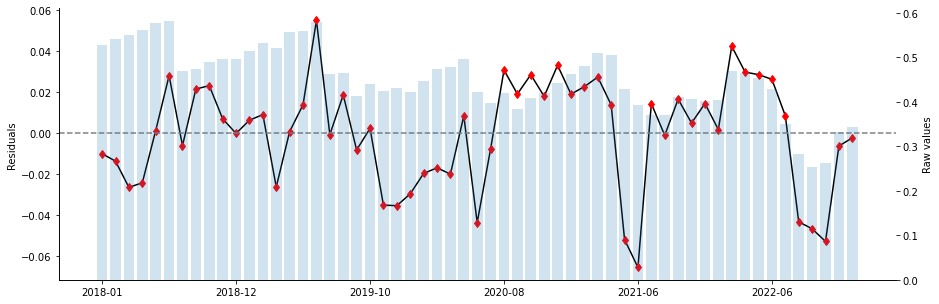

In [847]:
fig, ax = plt.subplots(figsize = (15, 5))

ax.plot(df.index, df['mean_value_resid'], 'k-')
ax.plot(df.index, df['mean_value_resid'], 'rd')
ax.axhline(y =0, color=  'grey', linestyle = '--')
ax.set_ylabel('Residuals')

ax1 = ax.twinx()
ax1.bar(df.index, df['mean_value'], alpha = 0.2)
ax1.set_ylabel('Raw values')

sns.despine()
ax.set_xticks([0, 10, 20, 30, 40, 50])
ax.set_xticklabels(df.loc[[0, 10, 20, 30, 40, 50]]['ym'].values)


plt.show()

#### Visualize the changes in this district

In [ ]:
#### Pre: Median over '2022-03-01' to'2022-05-31' 
#### Post: Median over '2022-10-01' to '2022-11-30'

In [850]:
df_dist1 = gpd.read_file("/data/sand_mining/rivers/districts/india-rivers_multipolygons_449.geojson")
dist_449 = geemap.geopandas_to_ee(df_dist1)

sand_pre = classification_pre.eq(1).clip(dist_449)
sand_post = classification_post.eq(1).clip(dist_449)

sand10 = sand_pre.eq(1).And(sand_post.eq(0))
sand01 = sand_pre.eq(0).And(sand_post.eq(1))
sand11 = sand_pre.eq(1).And(sand_post.eq(1))
sand00 = sand_pre.eq(0).And(sand_post.eq(0))

Map1 = geemap.Map(center = [25.22123 ,84.57627], zoom = 13)
Map1.addLayer(dist_449, {'color':'grey', 'alpha':0.3}, 'Rivers')
Map1.addLayer(finalComp_pre, visualization, 'S2-pre')
Map1.addLayer(finalComp_post, visualization, 'S2-post')
Map1.addLayer(sand_pre, {'palette':['black', 'yellow']}, 'Sand - pre')
Map1.addLayer(sand_post, {'palette':['black', 'yellow']}, 'Sand - post')
Map1.addLayer(sand10.selfMask(), {'palette':['red']}, 'Sand Loss')
Map1.addLayer(sand01.selfMask(), {'palette':['green']}, 'Sand Gain')
Map1

Map(center=[25.22123, 84.57627], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

##### Scrap/ Extra for now. 

In [526]:
sand_449 = sand_change.clip(dist_449)

In [551]:
reduceds = []
for eeobj in [sand10, sand01, sand11, sand00]:
    reduced = eeobj.reduceRegions(
                  reducer=ee.Reducer.sum(),
                  collection=dist_449,
                  scale=10, 
                  tileScale = 3
                   )

    reduceds.append(reduced)

In [555]:
reduceds[]

IndexError: list index out of range

In [538]:
r1 = sand_change.eq(0).reduceRegion(reducer = ee.Reducer.sum(), 
                               geometry = dist_449, 
                               scale = 10, 
                               tileScale = 3)

In [542]:
reduced

In [531]:
counts = reduced.values().get(0)
counts_keys = ee.Dictionary(counts).keys()
counts_values = ee.Dictionary(counts).values()

In [537]:
dist_449.geometry().area()

In [534]:
reduced.values()

In [532]:
counts_keys

In [533]:
counts_values

In [528]:
Map1 = geemap.Map(center=[25.16170, 76.61170], zoom = 11)
Map1.addLayer(sand_449,
            {'min': -1, 'max': 1, 'palette': ['008080', 'f3ff4a', 'c71585']},
            'sand')

Map1

Map(center=[25.1617, 76.6117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

In [234]:
legend_keys = ['None',   'sand',   'gravel','whitewater','water',  'bare' ,'greenveg', 'cobble']

palette = ['008080', 'f3ff4a', 'c71585','c0c0c0',    '2E86C1' ,'8c411d', '00854d', '551a4d' ];
visualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2'],
}



In [156]:
# # load your gemotry data (which should be in GeoJson file)
# import json
# with open("/data/sand_mining/rivers/rivers-osm-india_above50km.geojson") as f:
#     geojson = json.load(f)

# # construct a FeatureCollection object from the json object
# rivers_fc = ee.FeatureCollection(geojson)

# mbounds = ee.Geometry.Polygon(Map.getBounds())
# rivers_subset = rivers_fc.filterBounds(mbounds)
# df_river = gpd.read_file("/data/sand_mining/rivers/rivers-osm-india_above50km.geojson")

In [372]:
# Map = geemap.Map(center=[25.245937, 84.636020], zoom = 11)
# Map.addLayer(classification,
#             {'min': 0, 'max': len(palette)-1, 'palette': palette},
#             'Classification')
# Map.addLayer(classification_sgr, {'palette':'black'}, 'SGR')

# Map.addLayer(finalComp, visualization, 'S2-RGB')
# # Map.addLayer(rivers_fc, {}, 'Rivers')
# Map

In [198]:
from shapely.geometry import LineString, Polygon

In [257]:
df_rivers1 = gpd.read_file("/data/sand_mining/rivers/india-rivers_multipolygons.geojson")
temp1 = geemap.geopandas_to_ee(df_rivers1)
temp2 = temp1.filter(ee.Filter.bounds(ee.Geometry.Point(76.61170, 25.16170)))

In [273]:
Map1 = geemap.Map(center=[25.16170, 76.61170], zoom = 11)
Map1.addLayer(classification,
            {'min': 0, 'max': len(palette)-1, 'palette': palette},
            'Classification')
Map1.addLayer(finalComp, visualization, 'S2-RGB')
Map1.addLayer(temp, {}, "Chambal")
# Map1.addLayer(bounds_poly_fc, {}, 'Test bounds')
# Map1.addLayer(temp2,  {}, "Rivers")

Map1

Map(center=[25.1617, 76.6117], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

In [373]:
left,  bottom, right, top = Map1.getBounds()

In [374]:
print(left, bottom, right, top)

84.05641277676749 24.90263046793521 85.40223797208 25.64771645312254


In [283]:
from shapely.ops import unary_union
from shapely.geometry import box

In [375]:
# bounds_poly = gpd.GeoDataFrame(geometry=[Polygon([(left, top), 
#                                                   (right, top), 
#                                                   (right, bottom), 
#                                                   (left, bottom)])], crs=df_rivers1.crs)

# # df_rivers_temp = df_rivers1.clip(polygon)
bbox = (left,bottom,right, top)

# Clip the GeoPandas DataFrame to the bounding box
clipped_gdf = df_rivers1.cx[bbox[0]:bbox[2], bbox[1]:bbox[3]]
# clipped_gdf_utm = clipped_gdf.to_crs(clipped_gdf.estimate_utm_crs())
# clipped_gdf['area'] = 'test'
# clipped_gdf1 = clipped_gdf.dissolve('area')
gdf_union = unary_union(clipped_gdf.geometry)
# simplified_rivers = gdf_union.simplify(0.05).buffer(0.01).simplify(0.05)

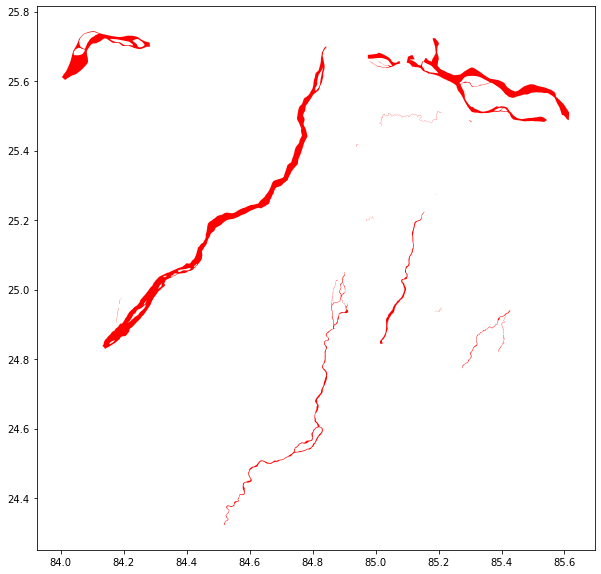

In [376]:
fig, ax = plt.subplots(figsize = (10, 10))
df_subset = gpd.GeoDataFrame(geometry = [gdf_union], crs = df_rivers1.crs)
df_subset.plot(facecolor = 'red', ax = ax)
plt.show()

In [381]:
105 * 1.6 * 111* 1.4

26107.199999999997

In [377]:
bounds_poly_fc = geemap.geopandas_to_ee(df_subset)

In [378]:
totalArea = bounds_poly_fc.geometry().area()

In [379]:
totalArea

In [382]:
576051245.6878963/1000000

576.0512456878962

In [383]:
eedict = ee.Dictionary.fromLists(list(range(0, 8)), legend_keys)
                                 
ee_landcover = classification.select('classification').clip(bounds_poly_fc);
                                 
counts = ee_landcover.reduceRegion(**{
  'reducer': ee.Reducer.frequencyHistogram(),
  'geometry':bounds_poly_fc,
  'scale': 10
}).values().get(0)


In [391]:
sand_mask = ee_landcover.eq(1)
gravel_mask = ee_landcover.eq(2)

sand_counts = sand_mask.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry':bounds_poly_fc,
  'scale': 10, 
  'tileScale':4
}).values().get(0)

gravel_counts = gravel_mask.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry':bounds_poly_fc,
  'scale': 10, 
  'tileScale':4
}).values().get(0)

In [396]:
gcount = gravel_counts.getInfo()
scount = sand_counts.getInfo()

EEException: Computation timed out.

In [394]:
out_dem_stats =  'dem_stats.csv'

# Allowed output formats: csv, shp, json, kml, kmz
# Allowed statistics type: MEAN, MAXIMUM, MINIMUM, MEDIAN, STD, MIN_MAX, VARIANCE, SUM
geemap.zonal_statistics(sand_mask, bounds_poly_fc, out_dem_stats, statistics_type='SUM', scale=10, tileScale = 4)

Computing statistics ...


Exception: Output of image computation is too large (9 bands for 2359296 pixels = 162.0 MiB > 80.0 MiB).
If this is a reduction, try specifying a larger 'tileScale' parameter.

In [387]:
counts_keys = ee.Dictionary(counts).keys()
counts_values = ee.Dictionary(counts).values()

# var new_counts_keys = counts_keys.map(function(ele) {
  
#   return dict.get(ele);
  
# })

In [390]:
import gc
gc.collect()

4842364

In [371]:
430505 * 100 + 47877.09019607844 *100

47838209.01960784

In [455]:
df_dist1 = gpd.read_file("/data/sand_mining/rivers/districts/india-rivers_multipolygons_449.geojson")
temp1 = geemap.geopandas_to_ee(df_dist1)

In [456]:
totalArea = temp1.geometry().area()

In [461]:
63808392.32047956/1e6

63.808392320479555

In [494]:
START_DATE

'2022-01-01'

In [491]:
sgr_img = get_sgr_feat(classification, 449)

In [469]:
task = ee.batch.Export.table.toDrive(
  collection= ee.FeatureCollection(sand_reduced),
  description='sand_dist1',
  fileFormat='CSV'
)

task.start()

In [464]:
reduced

In [467]:
278836.87843137264  *100 / 1e6

27.883687843137263